In [21]:
!gdown --id '151UEEw6bTO3g6JNdNFrpfPC2TAFUNk-0' --output china.xlsx

Downloading...
From: https://drive.google.com/uc?id=151UEEw6bTO3g6JNdNFrpfPC2TAFUNk-0
To: /content/china.xlsx
100% 103k/103k [00:00<00:00, 70.3MB/s]


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [24]:
def random_seed_setup(seed):
    # For reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        return 'cuda'
    else:
        return 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 0.01)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure()
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [25]:
class China(Dataset):
    def __init__(self,
                 input_array,
                 mode='train',
                 normalize='none',
                 target_only=False,
                 norm_mean=None,
                 norm_std=None):
        self.mode = mode

      
        data = np.array(input_array[0:])[:, 0:].astype(float)
        
        if not target_only:
            feats = list(range(1))
        else:
            pass

        if mode == 'test':
            # Testing data
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            else:
                indices = list(range(len(data)))
                # only when mode == 'train_all' (i.e., using all data for training)
            
            data = data[indices]
            target = target[indices]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data)
            self.target = torch.FloatTensor(target)
        
        self.norm_mean = None
        self.norm_std = None

        if normalize == 'self':
            self.norm_mean = self.data.mean(dim=0).unsqueeze(0)
            self.norm_std = self.data.std(dim=0).unsqueeze(0)
            self.data = (self.data - self.norm_mean) / self.norm_std

        if normalize == 'given' and (norm_mean is not None) and (norm_std is not None):
            self.data = (self.data - norm_mean) / norm_std

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of the Covid19 Dataset ({} samples found, each dim = {})'
              .format(mode, self.data.shape[0], self.data.shape[1]))

    def __getitem__(self, index):
        if self.mode in ['train', 'dev', 'train_all']:
            return self.data[index], self.target[index]
        else:
            return self.data[index]

    def __len__(self):
        return len(self.data)

In [26]:
def prep_dataloader(tr_path, tt_path, batch_size, n_jobs=0, target_only=False):
    tr_dataset = China(
        tr_path, mode='train_all',
        normalize='self', 
        target_only=target_only)

    dv_dataset = China(
        tr_path, mode='dev',
        normalize='given', 
        target_only=target_only,
        norm_mean=tr_dataset.norm_mean,
        norm_std=tr_dataset.norm_std)

    tt_dataset = China(
        tt_path, mode='test',
        normalize='given',
        target_only=target_only,
        norm_mean=tr_dataset.norm_mean,
        norm_std=tr_dataset.norm_std)
    
    tr_dataloader = DataLoader(
        tr_dataset, batch_size,
        shuffle=True, drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    
    dv_dataloader = DataLoader(
        dv_dataset, batch_size,
        shuffle=False, drop_last=False,
        num_workers=n_jobs, pin_memory=True)

    tt_dataloader = DataLoader(
        tt_dataset, batch_size,
        shuffle=False, drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    
    return tr_dataloader, dv_dataloader, tt_dataloader

In [27]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim, l2_reg=0.):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        self.net = nn.Sequential(
            nn.Linear(input_dim, 31),
            nn.RReLU(),  # randomized ReLU
            nn.Linear(31, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        self.l2_reg = l2_reg

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target, is_train=True):
        ''' Calculate loss '''
        total_loss = 0

        mse_loss = self.criterion(pred, target)
        total_loss += mse_loss
        if is_train and self.l2_reg > 0.:
            reg_loss = 0
            for param in self.parameters():
                reg_loss += torch.norm(param, p=2)
            total_loss += reg_loss * self.l2_reg
        
        return total_loss, mse_loss

In [36]:
def train(tr_set, dv_set, model, config, device):
    n_epochs = config['n_epochs']
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    loss_record = {'train': [], 'dev': []}
    min_mse = 1000.
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()
        for i, (x, y) in enumerate(tr_set):
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total_loss, mse_loss = model.cal_loss(pred, y, is_train=True)
            total_loss.backward()
            optimizer.step()
            loss_record['train'].append(total_loss.detach().cpu().item())

        dev_mse = dev(dv_set, model, device)

        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
        
        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))

    return min_mse, loss_record

def dev(dv_set, model, device):
    model.eval()
    total_loss = 0
    for x, y in dv_set:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            _, mse_loss = model.cal_loss(pred, y, is_train=False)
        total_loss += mse_loss.detach().cpu().item() * len(x)
    total_loss = total_loss / len(dv_set.dataset)
   # print('total_loss =', total_loss)
    return total_loss

In [37]:
device = random_seed_setup(42097)
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False

config = {
    'n_epochs': 10000,                  # maximum number of epochs
    'batch_size': 20,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,                # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

In [38]:
df = pd.read_excel('china.xlsx')
input = []
for i in range(2, df.shape[0]):
    input.append([df.iat[i, 0], df.iat[i, 6]])

In [39]:
len(input)

556

In [40]:
input[0]

[20527, 53]

In [41]:
tr_set, dv_set, tt_set = prep_dataloader(
    input, input, config['batch_size'], 
    target_only=target_only)

Finished reading the train_all set of the Covid19 Dataset (556 samples found, each dim = 1)
Finished reading the dev set of the Covid19 Dataset (56 samples found, each dim = 1)
Finished reading the test set of the Covid19 Dataset (556 samples found, each dim = 1)


In [42]:
model = NeuralNet(tr_set.dataset.dim, 0.001).to(device)

In [43]:
model_loss_record = train(tr_set, dv_set, model, config, device)

Finished training after 201 epochs


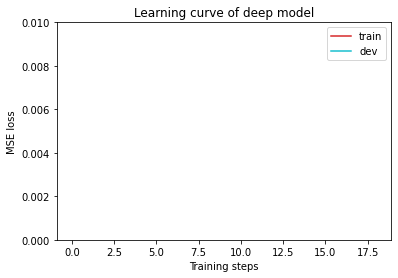

In [44]:
plot_learning_curve(model_loss_record[1], title='deep model')

In [45]:
model_loss_record[1]

{'dev': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,